In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import os
import math

# import data

In [2]:
def fix_mat(data):
    if data.dtype.names:
        new_data = dict()
        for name in data.dtype.names:
            new_data[name]=data[0][name][0]
        for k,v in new_data.items():
            if v.dtype.names:
                new_data[k] = fix_mat(v)
            else:
                new_data[k] = np.squeeze(v)
        return new_data
    else:
        return data

In [69]:
def extract_event(signal, event_extract, events):
    pos = events['POS'][events['TYP'] == event_extract] - 1 # the pose are in matlab format
    dur = events['DUR'][events['TYP'] == event_extract]
    mindur = min(dur) 
    c_signal = np.zeros((len(pos), mindur, signal.shape[1]))
    for i in range(len(pos)):
        c_signal[i] = signal[pos[i]:pos[i]+mindur]
    return c_signal

In [62]:
# general info
subject = 'c7'
day = '20250217'

interested_band = np.array([[8, 14]])
#interested_channel = np.array(['PO8', 'PO7', 'O1', 'P3'])

In [70]:
# for evalration file
path_calib = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/mat/cali_proc512.mat'
data_calib = loadmat(path_calib)
signals_calib = fix_mat(data_calib['signals'])
events_calib = fix_mat(data_calib['events'])
info_calib = fix_mat(data_calib['info'])
sampleRate = info_calib['sampleRate']
channels_label = info_calib['channel_labels']
bands = info_calib['bands']

interested_channel = channels_label
idx_interested_band = next(i for i, sub_arr in enumerate(bands) if np.array_equal(sub_arr, interested_band))
idx_interested_channel = [np.where([ch[0] == ic for ch in channels_label])[0][0] for ic in interested_channel]

signal_calib = signals_calib[idx_interested_band][0]
signal_calib = signal_calib[:, idx_interested_channel]
event_calib = events_calib
cf_calib = extract_event(signal_calib, 781, event_calib) # cf is trial x samples x channels
cueTYP_calib = event_calib['TYP'][np.isin(event_calib['TYP'], [730, 731])] # vector trial x 1
ntrial = len(cueTYP_calib)
interested_channel = channels_label

In [72]:
# for evaluation
path_eval = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/evaluation/mat/eva_proc512.mat'
data_eval = loadmat(path_eval)
signals_eval = fix_mat(data_eval['signals'])
events_eval = fix_mat(data_eval['events'])
info_eval = fix_mat(data_eval['info'])
sampleRate = info_eval['sampleRate']
channels_label = info_eval['channel_labels']
bands = info_eval['bands']

interested_channel = channels_label
idx_interested_band = next(i for i, sub_arr in enumerate(bands) if np.array_equal(sub_arr, interested_band))
idx_interested_channel = [np.where([ch[0] == ic for ch in channels_label])[0][0] for ic in interested_channel]

signal_eval = signals_eval[idx_interested_band][0]
signal_eval = signal_eval[:, idx_interested_channel]
event_eval = events_eval
cf_eval = extract_event(signal_eval, 781, event_eval) # cf is trial x samples x channels
cueTYP_eval = event_eval['TYP'][np.isin(event_eval['TYP'], [730, 731])] # vector trial x 1
ntrial = len(cueTYP_eval)

In [73]:
# create the dataset of the first 250 ms of the trial
start_time = 0 # s
end_time = 0.5 # s
sample_start = int(start_time * sampleRate)
sample_end = int(end_time * sampleRate)
X_calib_temp = cf_calib[:, sample_start:sample_end, :]
nsamples = X_calib_temp.shape[1]

X_calib = np.zeros((X_calib_temp.shape[0]* X_calib_temp.shape[1], X_calib_temp.shape[2]))
y_calib = np.zeros((X_calib_temp.shape[0]* X_calib_temp.shape[1], 1))
for idx_trial in range(ntrial):
    X_calib[idx_trial*nsamples:(idx_trial+1)*nsamples] = (X_calib_temp[idx_trial, :, :])
    y_calib[idx_trial*nsamples:(idx_trial+1)*nsamples] = cueTYP_calib[idx_trial]
y_calib = y_calib.ravel()

# start using last n-1 trials as test set
n = 20
start_test = nsamples * (ntrial - n)

X_train_calib = X_calib[:start_test,:]
y_train_calib = y_calib[:start_test].ravel()
X_test_calib = X_calib[start_test:,:]
y_test_calib = y_calib[start_test:].ravel()

print('Train set calibration:', X_train_calib.shape, y_train_calib.shape)
print('Test set calibration:', X_test_calib.shape, y_test_calib.shape)

# create the dataset of the first 250 ms of the trial
X_eval_temp = cf_eval[:, sample_start:sample_end, :]
nsamples = X_eval_temp.shape[1]

X_eval = np.zeros((X_eval_temp.shape[0]* X_eval_temp.shape[1], X_eval_temp.shape[2]))
y_eval = np.zeros((X_eval_temp.shape[0]* X_eval_temp.shape[1], 1))
for idx_trial in range(ntrial):
    X_eval[idx_trial*nsamples:(idx_trial+1)*nsamples] = (X_eval_temp[idx_trial, :, :])
    y_eval[idx_trial*nsamples:(idx_trial+1)*nsamples] = cueTYP_eval[idx_trial]
y_eval = y_eval.ravel()

# start using last n-1 trials as test set
n = 20
start_test = nsamples * (ntrial - n)

X_train_eval = X_eval[:start_test,:]
y_train_eval = y_eval[:start_test].ravel()
X_test_eval = X_eval[start_test:,:]
y_test_eval = y_eval[start_test:].ravel()

print('Train set evaluation:', X_train_eval.shape, y_train_eval.shape)
print('Test set evaluation:', X_test_eval.shape, y_test_eval.shape)

Train set calibration: (20480, 17) (20480,)
Test set calibration: (5120, 17) (5120,)
Train set evaluation: (20480, 17) (20480,)
Test set evaluation: (5120, 17) (5120,)


In [42]:
# rest of trial
X_calib_temp_restTrial = cf_calib[:, sample_end:,:]
nsamples = X_calib_temp_restTrial.shape[1]

X_calib_restTrial = np.zeros((X_calib_temp_restTrial.shape[0]* X_calib_temp_restTrial.shape[1], X_calib_temp_restTrial.shape[2]))
y_calib_restTrial = np.zeros((X_calib_temp_restTrial.shape[0]* X_calib_temp_restTrial.shape[1], 1))
for idx_trial in range(ntrial):
    X_calib_restTrial[idx_trial*nsamples:(idx_trial+1)*nsamples] = (X_calib_temp_restTrial[idx_trial, :, :])
    y_calib_restTrial[idx_trial*nsamples:(idx_trial+1)*nsamples] = cueTYP_calib[idx_trial]
    
y_calib_restTrial = y_calib_restTrial.ravel()

# Usefull functions

In [8]:
def print_cm(cm, title, tick_labels):
    cm = np.array(cm)
    cm = cm / cm.sum(axis=1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tick_labels)

    disp.plot()
    plt.show()

    

def print_cm_rej(model, X, y_true, th_rej, title, ticket_label):
    cm = [[0, 0], [0, 0]]
    y_probs = model.predict_proba(X)
    count_integrated = 0
    
    for idx_p in range(len(y_probs)):
        if y_true[idx_p] == 730 and y_probs[idx_p,0] > th_rej[0]:
            cm[0][0] += 1 
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 730 and y_probs[idx_p, 1] > th_rej[0]:
            cm[0][1] += 1
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 1] > th_rej[1]:
            cm[1][1] += 1
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 0] > th_rej[1]:
            cm[1][0] += 1
            count_integrated = count_integrated + 1
    
    # print accuracy
    print('Accuracy:', np.trace(cm)/np.sum(cm))
    print('Accuracy 730:', cm[0][0]/(cm[0][0]+cm[0][1]))
    print('Accuracy 731:', cm[1][1]/(cm[1][0]+cm[1][1]))
    print('Integrated: ', count_integrated, ' percentual: ', count_integrated/len(y_probs), '%')   
    print_cm(cm, title, ticket_label)
    
def accuracy_online(prob, hit, miss, timeout, target, ths):
        
    i1 = np.where(prob[:,0] > ths[0])[0]
    if len(i1) == 0:
        i1 = len(prob[:,0]) + 1
    else:
        i1 = i1[0]
    i2 = np.where(prob[:,1] > ths[1])[0]
    if len(i2) == 0:
        i2 = len(prob[:,1]) + 1
    else:
        i2 = i2[0]
        
        
    
    if (target == 730 and i1 < i2) or (target == 731 and i1 > i2):
        hit += 1
    elif (target == 730 and i1 > i2) or (target == 731 and i1 < i2):
        miss += 1
    elif i1 == i2:
        timeout += 1
        
    return hit, miss, timeout
    
def histo_prediction(X, model, bins_step, classes):
    probs = model.predict_proba(X)
    bins = np.arange(0, 1.0+bins_step, bins_step)
    figure = plt.figure(figsize=(5, 3))
    plt.hist(probs[:,0], bins=bins)
    # Add title and labels
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title('Probability Distribution of class ' + classes[0])
    plt.xlabel('Probability')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()
    

In [9]:
def sim_online_expo_buffer(model, X, y, buffer_size, ths_integrated, ths_rej, alpha): 
# TODO: generalize for not intial percentual = 0.5
    # look only test data
    %matplotlib qt
    y_inter = 0.5
    tmp = info['startTrial']
    tmp2 = info['startTrial']
    tmp2 = np.append(tmp2, X.shape[0])
    tmp2 = tmp2[1:len(tmp2)]
    cfStart = tmp[tmp >= start_test] - start_test - 1 # -1 since it is from matlab
    cfDUR = (tmp2-tmp).ravel()
    cfDUR = cfDUR[tmp >= start_test] 

    maxDUR = np.max(cfDUR)

    fig, axs = plt.subplots(math.ceil(len(cfStart)/4), 4, sharex=True, sharey=True)
    fig.set_size_inches(15,10)
    hit_B, miss_B, timeout_B, hit_E, miss_E, timeout_E = 0, 0, 0, 0, 0, 0
    # iteration over trials
    for i in range(len(cfStart)):

        buffer = np.array([730 if i % 2 == 0 else 731 for i in range(buffer_size)])

        c_start = cfStart[i]
        c_end = c_start + cfDUR[i]

        c_y_B = np.array([[0.5, 0.5]])
        c_y_E = np.array([[0.5, 0.5]])
        pred = model.predict_proba(X[c_start:c_end,:])
        pred_prob = [sublist[0] for sublist in pred] # contains only 730 probabilities

        index = 0
        for j in range(len(pred)):
            if index == buffer_size:
                index = 0
            c_prob = pred[j]
            
            # integrated for the buffer integrator
            if c_prob[0] == 0.5:
                c_y_B = np.vstack([c_y_B, [np.sum(buffer == 730)/buffer_size, np.sum(buffer == 731)/buffer_size]])
            elif c_prob[0] >= ths_rej[0]:
                buffer[index] = 730
                # compute percentual values
                c_y_B = np.vstack([c_y_B, [np.sum(buffer == 730)/buffer_size, np.sum(buffer == 731)/buffer_size]])
                index = index + 1
            elif c_prob[1] >= ths_rej[1]:
                buffer[index] = 731
                # compute percentual values
                c_y_B = np.vstack([c_y_B, [np.sum(buffer == 730)/buffer_size, np.sum(buffer == 731)/buffer_size]])
                index = index + 1
            else:
                c_y_B = np.vstack([c_y_B, [np.sum(buffer == 730)/buffer_size, np.sum(buffer == 731)/buffer_size]])
            
            # integrate for the exponential
            idx_max = np.argmax(pred[j])
            if c_prob[idx_max] > ths_rej[idx_max]:
                prob = np.zeros(len(c_prob))  
                prob[idx_max] = 1.0  
                c_t = alpha * c_y_E[-1,:] + (1 - alpha) * prob
                c_y_E = np.vstack([c_y_E, c_t])
            elif c_prob[idx_max] == 0.5:
                c_y_E = np.vstack([c_y_E, c_y_E[-1,:]])
                

        prev_hit_B = hit_B
        prev_miss_B = miss_B
        prev_timeout_B = timeout_B
        [hit_B, miss_B, timeout_B] = accuracy_online(c_y_B, hit_B, miss_B, timeout_B, y[cfStart[i]], ths_integrated)
        prev_hit_E = hit_E
        prev_miss_E = miss_E
        prev_timeout_E = timeout_E
        [hit_E, miss_E, timeout_E] = accuracy_online(c_y_E, hit_E, miss_E, timeout_E, y[cfStart[i]], ths_integrated)

        axs[int(i/4), i%4].plot(c_y_B[:,0]) # first column is 730 
        axs[int(i/4), i%4].plot(c_y_E[:,0]) # first column is 730 
        axs[int(i/4), i%4].scatter(range(len(pred_prob)), pred_prob, color='black')
        axs[int(i/4), i%4].hlines(y_inter, 0, len(c_y_B), colors='r')
        axs[int(i/4), i%4].set_xlim([0, maxDUR])
        axs[int(i/4), i%4].set_xticks(np.arange(0, maxDUR, 16))
        axs[int(i/4), i%4].set_xticklabels(np.arange(0, maxDUR, 16)/16.0)
        axs[int(i/4), i%4].hlines(ths_rej[0], 0, len(c_y_B), colors='r', linestyle='--')
        axs[int(i/4), i%4].hlines(1.0-ths_rej[1], 0, len(c_y_B), colors='r', linestyle='--')
        axs[int(i/4), i%4].hlines(ths_integrated[0], 0, len(c_y_B), colors='g', linestyle='--')
        axs[int(i/4), i%4].hlines(1.0 -ths_integrated[1], 0, len(c_y_B), colors='g', linestyle='--')
        if hit_B-prev_hit_B != 0:
            c_title = f'{y[cfStart[i]]} hit Buffer'
        elif miss_B - prev_miss_B != 0:
            c_title = f'{y[cfStart[i]]} miss Buffer'
        elif timeout_B - prev_timeout_B != 0:
            c_title = f'{y[cfStart[i]]} timeout Buffer'
            
        if hit_E-prev_hit_E != 0:
            c_title += f'| {y[cfStart[i]]} hit Expo'
        elif miss_E - prev_miss_E != 0:
            c_title += f'| {y[cfStart[i]]} miss Expo'
        elif timeout_E - prev_timeout_E != 0:
            c_title += f'| {y[cfStart[i]]} timeout Expo'
        axs[int(i/4), i%4].set_title(c_title)

    print(f'Online accuracy buffer: {hit_B/(hit_B+miss_B+timeout_B)}, hit: {hit_B}, miss: {miss_B}, timeout: {timeout_B}')
    print(f'Online accuracy eponential: {hit_E/(hit_E+miss_E+timeout_E)}, hit: {hit_E}, miss: {miss_E}, timeout: {timeout_E}')

    plt.tight_layout()
    plt.show()

In [76]:
sim_online_expo_buffer(model_qda, X, y, 48, [0.75, 0.75], [0.55, 0.55], 0.97)

NameError: name 'info' is not defined

# QDA

In [40]:
param_grid = {'reg_param': [0.0, 0.1, 0.5, 1.0], 'priors': [None, [0.5, 0.5]]}

#grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train_calib, y_train_calib)

#print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'priors': None, 'reg_param': 0.0}
Best score found:  1.0


In [51]:
X_train_calib = X_train_calib[range(0, X_train_calib.shape[0], 32),:]
y_train_calib = y_train_calib[range(0, y_train_calib.shape[0], 32)]

In [54]:
X_train_calib.shape

(640, 17)

In [60]:
np.unique(X_train_calib, return_counts=True)

(array([-1.92774225, -1.87818622, -1.84022317, ...,  2.41188006,
         2.42220081,  2.46765988]),
 array([4, 4, 4, ..., 4, 4, 4]))

In [52]:
model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
model_qda.fit(X_train_calib, y_train_calib)

print(f'Calibration 0-{end_time} s')
print(f'   Accuracy calibration train: {model_qda.score(X_train_calib, y_train_calib)}')
print(f'   Accuracy calibration test:  {model_qda.score(X_test_calib, y_test_calib)}')
print(f'   Accuracy calibration all:   {model_qda.score(X_calib, y_calib)}')
print(f'All the other part of the trial')
print(f'   Accuracy calibration all:   {model_qda.score(X_calib_restTrial, y_calib_restTrial)}')

#print(f'Accuracy evaluation train: {model_qda.score(X_train_eval, y_train_eval)}')
#print(f'Accuracy evaluation test:  {model_qda.score(X_test_eval, y_test_eval)}')
print(f'Accuracy evaluation all:   {model_qda.score(X_eval, y_eval)}')

Calibration 0-0.5 s
   Accuracy calibration train: 1.0
   Accuracy calibration test:  1.0
   Accuracy calibration all:   1.0
All the other part of the trial
   Accuracy calibration all:   0.4929772234273319
Accuracy evaluation all:   0.4765625


In [43]:
# train over all the dataset
model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
model_qda.fit(X_calib, y_calib)

print(f'Accuracy calibration all:   {model_qda.score(X_calib, y_calib)}')
print(f'Accuracy evaluation all:   {model_qda.score(X_eval, y_eval)}')

Accuracy calibration all:   0.7715625
Accuracy evaluation all:   0.400625


CALIBRATION:
Accuracy: 0.7715625
Accuracy 730: 0.826875
Accuracy 731: 0.71625
Integrated:  25600  percentual:  1.0 %


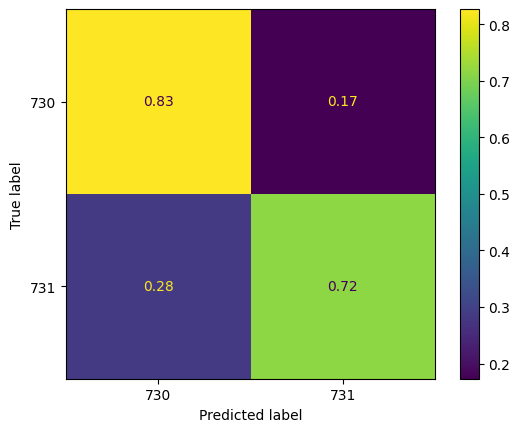

Accuracy: 0.7715625
Accuracy 730: 0.826875
Accuracy 731: 0.71625
Integrated:  6400  percentual:  1.0 %


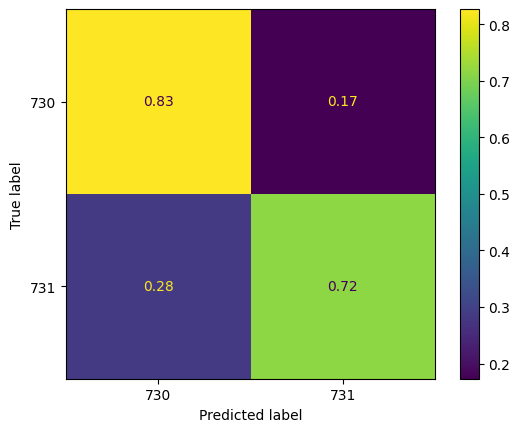

Accuracy: 0.7715625
Accuracy 730: 0.826875
Accuracy 731: 0.71625
Integrated:  32000  percentual:  1.0 %


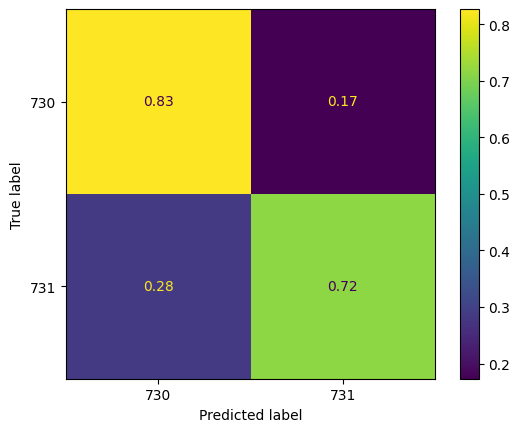

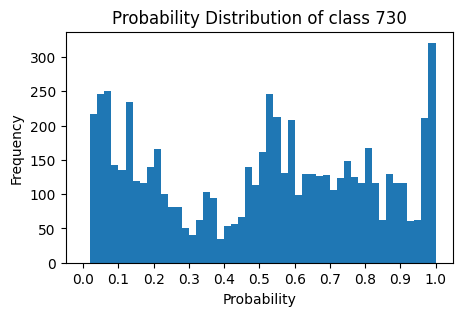

EVALUATION:
Accuracy: 0.400625
Accuracy 730: 0.5284375
Accuracy 731: 0.2728125
Integrated:  25600  percentual:  1.0 %


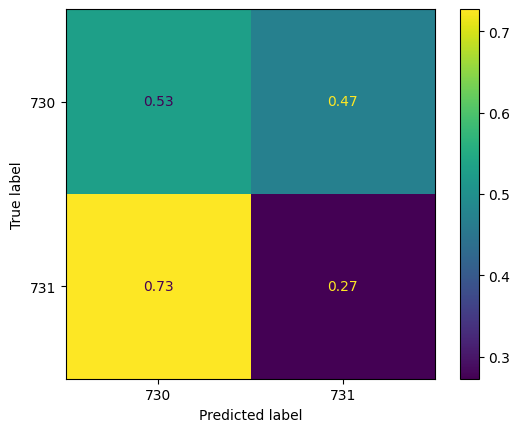

Accuracy: 0.400625
Accuracy 730: 0.5284375
Accuracy 731: 0.2728125
Integrated:  6400  percentual:  1.0 %


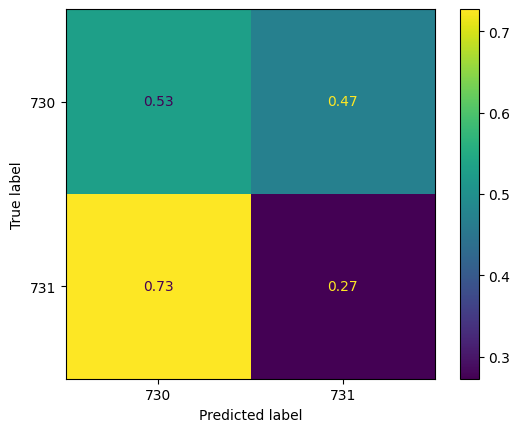

Accuracy: 0.400625
Accuracy 730: 0.5284375
Accuracy 731: 0.2728125
Integrated:  32000  percentual:  1.0 %


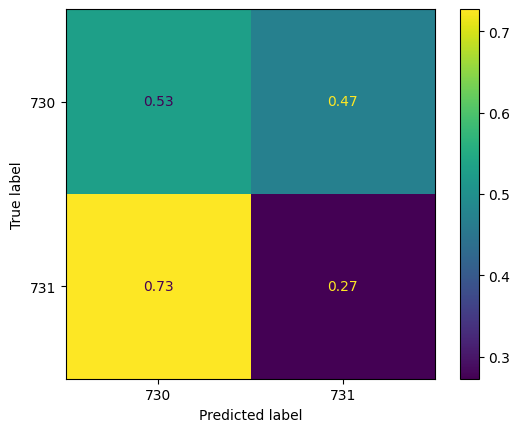

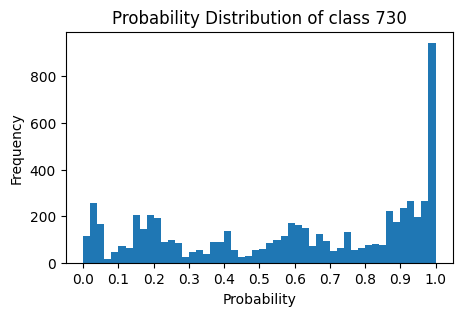

In [44]:
ths_rej = [0.5, 0.5]
bins_step = 0.02

print('CALIBRATION:')
print_cm_rej(model_qda, X_train_calib, y_train_calib, ths_rej, 'train set',  ['730', '731'])
print_cm_rej(model_qda, X_test_calib,  y_test_calib,  ths_rej, 'test set',  ['730', '731'])
print_cm_rej(model_qda, X_calib,  y_calib,  ths_rej, 'all dataset',  ['730', '731'])

histo_prediction(X_test_calib, model_qda, bins_step, classes=['730', '731'])

print('EVALUATION:')
print_cm_rej(model_qda, X_train_eval, y_train_eval, ths_rej, 'train set',  ['730', '731'])
print_cm_rej(model_qda, X_test_eval,  y_test_eval,  ths_rej, 'test set',  ['730', '731'])
print_cm_rej(model_qda, X_eval,  y_eval,  ths_rej, 'all dataset',  ['730', '731'])

histo_prediction(X_test_eval, model_qda, bins_step, classes=['730', '731'])

# Save QDA

In [43]:
# save qda model for sklearn
from ruamel.yaml import YAML
from ruamel.yaml.scalarstring import LiteralScalarString

features_label = []
for i in range(0, len(info['chSelected'].tolist())):
    features_label.append(str(info['channelsLabel'][info['chSelected'][i] - 1][0]))

files = []
for i in range(0, len(info['files'])):
    str_file = info['files'][i][0]
    files.append(str(str_file))
    
band = info['bandSelected'].tolist()
id_ch = info['chSelected'].tolist()

model_params = {
    'QdaCfg': {
        'name': "qda",
        'params': {
            'subject': subject,
            'filename': 'qda',
            'filename_dataset': path,
            'files': files,
            'type_data': type_,
            'nclasses': int(len(model_qda.classes_)),
            'classlbs': model_qda.classes_.tolist(),
            'nfeatures': int(model_qda.n_features_in_),
            'chans': features_label,
            'idchans': id_ch, 
            'note': 'idchans are saved in matlab convention, instead the names are correct',
            'sampleRate': int(info['sampleRate']),
            'band': band,
            'filterOrder': int(info['filterOrder']),
            'priors': model_qda.priors_.tolist(),
            'means': model_qda.means_.tolist(),
            'covs': [arr.tolist() for arr in model_qda.covariance_],
            'rotations': [arr.tolist() for arr in model_qda.rotations_],
            'scalings': [arr.tolist() for arr in model_qda.scalings_]
        }
    }
}

# Save parameters to a YAML file
c_dir = os.getcwd()
c_prev = os.path.abspath(os.path.join(c_dir, os.pardir))
path2save = c_prev + '/cfg/qda_' + subject + '_lbp_' + day + '.yaml'

yaml = YAML()
with open(path2save, 'w') as file:
    yaml.dump(model_params, file)
    
print(path2save)

/home/paolo/cvsa_ws/src/qda_cvsa/cfg/qda_f2_lbp_20250304.yaml


# LDA

In [45]:
param_grid = {'solver': [ 'lsqr', 'eigen'], 'shrinkage': ['auto', None]}

#grid_search = GridSearchCV(estimator=LinearDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=LinearDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train_calib, y_train_calib)

print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

model_lda = LinearDiscriminantAnalysis(solver=grid_search.best_params_['solver'], shrinkage=grid_search.best_params_['shrinkage'])
model_lda.fit(X_train_calib, y_train_calib)

print(f'Accuracy train: {model_lda.score(X_train_calib, y_train_calib)}')
print(f'Accuracy test:  {model_lda.score(X_test_calib, y_test_calib)}')
print(f'Accuracy all:   {model_lda.score(X_calib, y_calib)}')

model_lda = LinearDiscriminantAnalysis(solver=grid_search.best_params_['solver'], shrinkage=grid_search.best_params_['shrinkage'])
model_lda.fit(X_calib, y_calib)
print(f'Accuracy all:   {model_lda.score(X_calib, y_calib)}')
print(f'Accuracy eval all:   {model_lda.score(X_eval, y_eval)}')

Results:  {'mean_fit_time': array([0.0542345 , 0.04525089, 0.0238028 , 0.02304745]), 'std_fit_time': array([0.00919783, 0.00312713, 0.0028829 , 0.00465757]), 'mean_score_time': array([0.00233641, 0.00176506, 0.00179815, 0.00155025]), 'std_score_time': array([0.00060273, 0.00020176, 0.00022362, 0.00028478]), 'param_shrinkage': masked_array(data=['auto', 'auto', None, None],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['lsqr', 'eigen', 'lsqr', 'eigen'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'shrinkage': 'auto', 'solver': 'lsqr'}, {'shrinkage': 'auto', 'solver': 'eigen'}, {'shrinkage': None, 'solver': 'lsqr'}, {'shrinkage': None, 'solver': 'eigen'}], 'split0_test_score': array([0.80234375, 0.80234375, 0.80253906, 0.80253906]), 'split1_test_score': array([0.63398438, 0.63398438, 0.63398438, 0.63398438]), 'split2_test_score': array([

## SVM

In [46]:
#from sklearn.svm import SVC
from cuml.svm import SVC  # Import cuML's GPU-accelerated SVM
from cuml.model_selection import GridSearchCV  # GPU-based GridSearchCV

param_grid = {'kernel': [1.0 * RBF(length_scale=1.0), 2.0 * RBF(length_scale=1.0), 3.0 * RBF(length_scale=1.0), 2.0 * RBF(length_scale=2.0)],
              'C' : np.logspace(-2, 4, 3),
              'gamma' : np.logspace(-9, 3, 3)}

grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train_calib, y_train_calib)
#grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=3).fit(X_train, y_train)

print("The best parameters are %s with a score of %0.4f" % (grid_search.best_params_, grid_search.best_score_))

svm = SVC(kernel=grid_search.best_params_['kernel'], C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'], probability=True)
svm.fit(X_train_calib, y_train_calib)
print(f'Accuracy train: {svm.score(X_train_calib, y_train_calib)}')
print(f'Accuracy test:  {svm.score(X_test_calib, y_test_calib)}')
print(f'Accuracy all:   {svm.score(X_calib, y_calib)}')
print(f'Accuracy all:   {svm.score(X_eval, y_eval)}')

## Gaussian

In [11]:
from sklearn.gaussian_process import GaussianProcessClassifier
param_grid = {'kernel': [1.0 * RBF(length_scale=1.0), 
                         1.0 * Matern(length_scale=1.0, nu=1.5)]}
#grid_search = GridSearchCV(estimator=GaussianProcessClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
grid_search = GridSearchCV(estimator=GaussianProcessClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=3).fit(X_train_calib, y_train_calib)

print("Results: ", grid_search.cv_results_)
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

model_gaussian = GaussianProcessClassifier(kernel=grid_search.best_params_['kernel'])
model_gaussian.fit(X_train_calib, y_train_calib)

print(f'Accuracy train: {model_gaussian.score(X_train_calib, y_train_calib)}')
print(f'Accuracy test:  {model_gaussian.score(X_test_calib, y_test_calib)}')
print(f'Accuracy all:   {model_gaussian.score(X_calib, y_calib)}')
print(f'Accuracy all:   {model_gaussian.score(X_eval, y_eval)}')

Fitting 3 folds for each of 2 candidates, totalling 6 fits


## random forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

model_rF = RandomForestClassifier()

param_dist = {'n_estimators': randint(0, 500), 'max_depth': randint(1, X.shape[1])}
#rand_search = RandomizedSearchCV(model_rF, param_distributions= param_dist, n_iter=15, cv=5, verbose=3).fit(X_train, y_train)
rand_search = RandomizedSearchCV(model_rF, param_distributions= param_dist, n_iter=15, cv=5).fit(X_train_calib, y_train_calib)

#print(rand_search.cv_results_)
#print('Best hyperparameters:', rand_search.best_params_)
print('Best score:', rand_search.best_score_)

model_rF = rand_search.best_estimator_
model_rF.fit(X_train_calib, y_train_calib)  

print(f'Accuracy train: {model_rF.score(X_train_calib, y_train_calib)}')
print(f'Accuracy test:  {model_rF.score(X_test_calib, y_test_calib)}')
print(f'Accuracy all:   {model_rF.score(X_calib, y_calib)}')
print(f'Accuracy all:   {model_rF.score(X_eval, y_eval)}')